# Transferlearning

We have seen that convolutional neural networks are able to extract abstract spatial features that are common within the training set and are sufficient to classify images into different classes. Looking at the kernels that resulted from the MNIST dataset it is hard to imagine that these kernels could be of general use, however. This is not the case for more general images such as the CIFAR dataset. One can imagine, that a detector that has been trained on a very large number (60000) of very general images actually does lead to a fairly general set of kernels. If that is so, a network could be trained on additional or new images without actually touching the convolutional part. This is known as <i>Transferlearning</i>. 

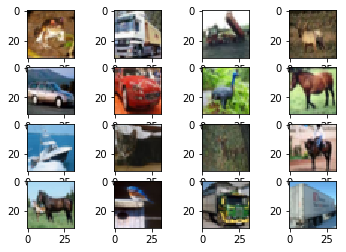

In [15]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

import matplotlib.pyplot as plt

for I in range(4):
    for J in range(4):
        plt.subplot(4,4,I*4+J+1)
        plt.imshow(x_train[I*4+J,:,:,:])

Training a classifer with 79% accuracy for the CIFAR dataset took a little less than an hour on a simple computer. What about a set of kernels that have been trained on millions of images that takes weeks or months to train? How about a set of kernels that has been trained to extract patterns millions of hours of human speech or even video? Making such kernels available might enable individuals and small companies to leverage the power of deep learning for their applications without the resources that are needed to train networks using so much data or even collect them. 

Although the distinction between the "convolutional" and the "dense" part is intuitive, <b>what</b> part of the network to choose is much less obvious in practice. It is also rarely the case that the application to which we want to transfer to is using the exact same data as input. For example, the CIFAR classifier has been trained on 32x32, square images. How can this be adapted to a dataset with larger images (except for throwing away the additional data)? What about images that have been recorded by a different camera and specific lightning conditions? Does a model that has been trained on outdoor image contain anything that can be reused for indoor images? In the worst case, transferring parts of a network make things worse, also known as <i>negative transfer</i>, making it harder for training to recover than training from scratch. 

The field of transfer learning is large, the questions treated therein are subtle, and not limited to deep learning. A good overview is provided in the article <a href="https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a">A comprehensive hands on guide to transfer learning with real world applications in deep learning</a> and the research paper <a href="https://www.cse.ust.hk/~qyang/Docs/2009/tkde_transfer_learning.pdf">A survey on transfer learning</a>.

Transfer learning in a deep learning context is known as <i>inductive learning</i>, which in contrast to <i>unsupervised transfer learning</i> does have labeled data in a target domain. Depending on whether labeled data is available in a source domain or not, we are talking about <i>multi-task learning</i> or <i>self-taught learning</i>. The latter, self-taught learning, is a situation in which we obtain a pre-trained network and apply it to a similar category, but do not take advantage of the original training set. 

## Pre-trained Models as Feature Extractors

One of the most prominent pre-trained models are VGG (University of Oxford), ImageNet (Google) and Inception (Microsoft). We can download a model like VGG and extract individual layers, in this case we are creating a new model that only includes everything up to the "block4_pool" layer and inspect what kind of feature maps are created for the cat image.

<center>
    <img src="figs/cat.jpg">
</center>

0 input_2 (None, 224, 224, 3)
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 flatten (None, 25088)
20 fc1 (None, 4096)
21 fc2 (None, 4096)
22 predictions (None, 1000)


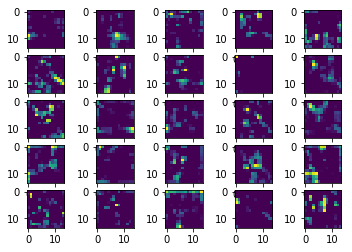

In [8]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# pre-built and pre-trained deep learning VGG16 model
base_model = VGG16(weights='imagenet', include_top=True)
for i, layer in enumerate(base_model.layers):
     print (i, layer.name, layer.output_shape)

# extract features from block4_pool block
model =Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
img_path = 'figs/cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# get the features from this block
features = model.predict(x)

for I in range(25):
    plt.subplot(5,5,I+1)
    plt.imshow(features[0,:,:,I])


The goal would now be to recycle this part of the network (a few hundred megabytes of weight) for our own training. The output of the VGG16 trunk is of dimension (1,14,14,512), that is 512 14x14 feature maps. In order to use these as a classifier, we need at the very least to flatten this output, add a dense hidden layer, and finally a softmax-activated output. 

Assuming that the feature maps are already pretty distinctive - and we do have 512 of them - we can also try to use <code>GlobalAveragePooling2D</code>, which is an average pooling step that flattens the 512 feature maps into 512 single neurons. 

In [9]:
from keras.layers import Dense, GlobalAveragePooling2D

x = base_model.get_layer('block4_pool').output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10,activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

We now want to make sure that our new dense output layer is actually trained. This one requires only 512x10+10 parameters. This can be seen in the model summary below. 

In [10]:
from keras.optimizers import Adam
for layer in base_model.layers: 
    layer.trainable = False
    

model.compile(optimizer=Adam(), loss='categorical_crossentropy')
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

We can now try to use this network to train a classifier for the CIFAR10 dataset.

In [11]:
import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Conv2D, MaxPooling2D

#import os

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

batch_size = 128
num_classes = 10
epochs = 20

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
import cv2

x_train_large = np.zeros((50000,224,224,3))
for I in range(x_train.shape[0]):
    x_train_large[I,:,:,:]=res = cv2.resize(x_train[I,:,:,:], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

(50000, 224, 224, 3)

In [16]:
model.fit(x_train_large, y_train, batch_size=128, epochs=1, verbose=1, validation_split=0.1)

ValueError: Error when checking target: expected dense_1 to have shape (10,) but got array with shape (1,)

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])